In [1]:
import os
import anndata as ad
import scanpy as sc
import pyBigWig as pb
import pandas as pd

    
binsizes = [5000, 20000, 50000, 100000]
chrom_sizes = pd.read_csv(
    '../resource/grcm38_chromsizes.tsv',
    sep = '\t',
    header = None,
    names = ['chrom', 'length']
)

# Reading raw data and saving to easy access format

In [2]:
# import glob
# from functools import partial
# import multiprocessing as mp
# from laminatools import io


# for binsize in binsizes:
#     print(binsize)
#     bin_frame = io.make_bin_frame_from_chrom_sizes(chrom_sizes, binsize)
    
#     func = partial(
#         io.read_bigwig,
#         bin_frame = bin_frame,
#         binsize = binsize
#     )
        
#     p = mp.Pool(4)
#     results = p.map(func, glob.glob(f'../bigwigs/*{binsize}.bw'))
#     p.close()
#     bin_frame = pd.concat(results, axis = 1)

#     bin_frame.to_hdf(
#         '../count_frames.h5',
#         f'bs{binsize}',
#         mode = 'a'
#     )

In [3]:
# import multiprocessing as mp
# from functools import partial

# conditions = ['WT', 'KO']
# segment_string = '../models/chromhmm_design_{condition}_model_{binsize}_{states}/mouse_cell_{states}_segments.bed'
# for binsize in binsizes:
#     for condition in conditions:
#         func = partial(
#             io.read_segmentation,
#             segment_string = segment_string,
#             binsize = binsize,
#             condition = condition
#         )
#         p = mp.Pool(4)
#         results = p.map(func, range(5, 11))
#         p.close()
        
#         segmentation_frame = pd.concat(results, axis = 1)
#         segmentation_frame.to_hdf(
#             '../segmentation_frames.h5',
#             f'{condition}_{binsize}',
#             mode = 'a'
#         )
#         del results, segmentation_frame
#         gc.collect()

# Analysing data

In [4]:
conditions = ['WT', 'KO']
state_frames = {k: {} for k in conditions}
for condition in conditions:
    for binsize in binsizes:
        key = f'{condition}_{binsize}'
        state_frames[condition][binsize] = pd.read_hdf('../segmentation_frames.h5', key)

In [5]:
frames = {k: {} for k in conditions}
for binsize in binsizes:
    key = f'bs{binsize}'
    df = pd.read_hdf('../count_frames.h5', key)
    df = df.loc[~df.isna().all(axis = 1), :].fillna(0)
    df = df.divide(df.sum(axis = 0)/1e6) # normalize RPM
    for condition in conditions:
        condition_frame = df.loc[:, df.columns.str.contains(condition)].copy()
        for cycles in [16, 20]:
            input_columns = condition_frame.columns.str.contains(f'INPUT_{condition}_{cycles}')
            chip_columns = condition_frame.columns.str.contains('chipseq') & condition_frame.columns.str.endswith(f'{cycles}') & ~input_columns
            condition_frame.loc[:, chip_columns] = condition_frame.loc[:, chip_columns].subtract(
                condition_frame.loc[:, input_columns].mean(axis = 1), 
                axis = 0
            )
        
        condition_frame = condition_frame \
            .drop(columns = condition_frame.columns[condition_frame.columns.str.contains('INPUT')]) \
            .clip(lower = 0)
        
        data_columns = ['atacseq', 'rnaseq']
        
        average_frame_list = []
        for data in data_columns:
            average_frame_list.append(
                condition_frame.loc[:, condition_frame.columns.str.contains(data)].mean(axis = 1)
            )
            
        columns_to_drop = []
        for col in data_columns:
            columns_to_drop.extend(
                condition_frame.columns[condition_frame.columns.str.startswith(col)].to_list()
            )
        
        condition_frame.drop(
            columns = columns_to_drop,
            inplace = True
        )
        
        average_frame = pd.concat(average_frame_list, axis = 1)
        average_frame.columns = [f'{col}_{condition}' for col in data_columns]
        
        condition_frame = condition_frame.merge(
            average_frame,
            left_index = True,
            right_index = True,
            how = 'left'
        )
        
        if condition == 'WT':
            lap2a = condition_frame.loc[:, condition_frame.columns.str.contains('LAP2')]
        
        if condition == 'KO':
            condition_frame = condition_frame.merge(
                lap2a,
                left_index = True,
                right_index = True,
                how = 'left'
            )
        
        frames[condition][binsize] = condition_frame

In [6]:
frames['KO'][5000]

,chipseq_BRG1_KO_16,chipseq_BRG1_KO_20,chipseq_CHD4_KO_16,chipseq_CHD4_KO_20,chipseq_laminA_3A6_KO_16,chipseq_laminA_3A6_KO_20,chipseq_laminA_E1_KO_16,chipseq_laminA_E1_KO_20,atacseq_KO,rnaseq_KO,chipseq_LAP2alpha_WT_16,chipseq_LAP2alpha_WT_20
1:3000000-3005000,0.000000,0.000000,0.000000,0.418741,1.207803,0.867446,0.550770,0.207476,0.303830,0.000000,0.234772,0.225434
1:3005000-3010000,0.000000,0.000000,0.000000,0.000000,1.795684,0.638398,1.513677,0.699756,0.361164,0.000000,1.548198,1.028162
1:3010000-3015000,0.000000,0.000000,0.000000,0.000000,1.225513,1.039363,0.548427,0.678483,0.256854,0.000000,0.151079,0.779562
1:3015000-3020000,0.000000,0.000000,0.000000,0.000000,0.862834,0.699198,0.499351,0.694140,0.318466,0.000000,1.253475,0.282361
1:3020000-3025000,0.000000,0.000000,0.000000,0.000000,0.715224,0.921956,0.392606,0.797399,0.273630,0.000000,0.296643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Y:90820000-90825000,0.000000,0.000000,0.046865,0.000000,0.302795,0.158813,0.000000,0.147720,0.490956,1.253740,0.105515,0.000000
Y:90825000-90830000,0.082688,0.000000,0.148923,0.579149,0.323882,0.000000,0.050638,0.030357,2.863839,0.046637,0.052758,0.000000
Y:90830000-90835000,0.000000,0.089369,0.000000,0.000000,0.000000,0.211751,0.050638,0.000000,4.254969,0.107748,0.052758,0.000000
Y:90835000-90840000,0.000000,0.135236,0.000000,0.579149,0.000000,0.062372,0.000000,0.000000,8.118375,0.762382,0.000000,0.305528


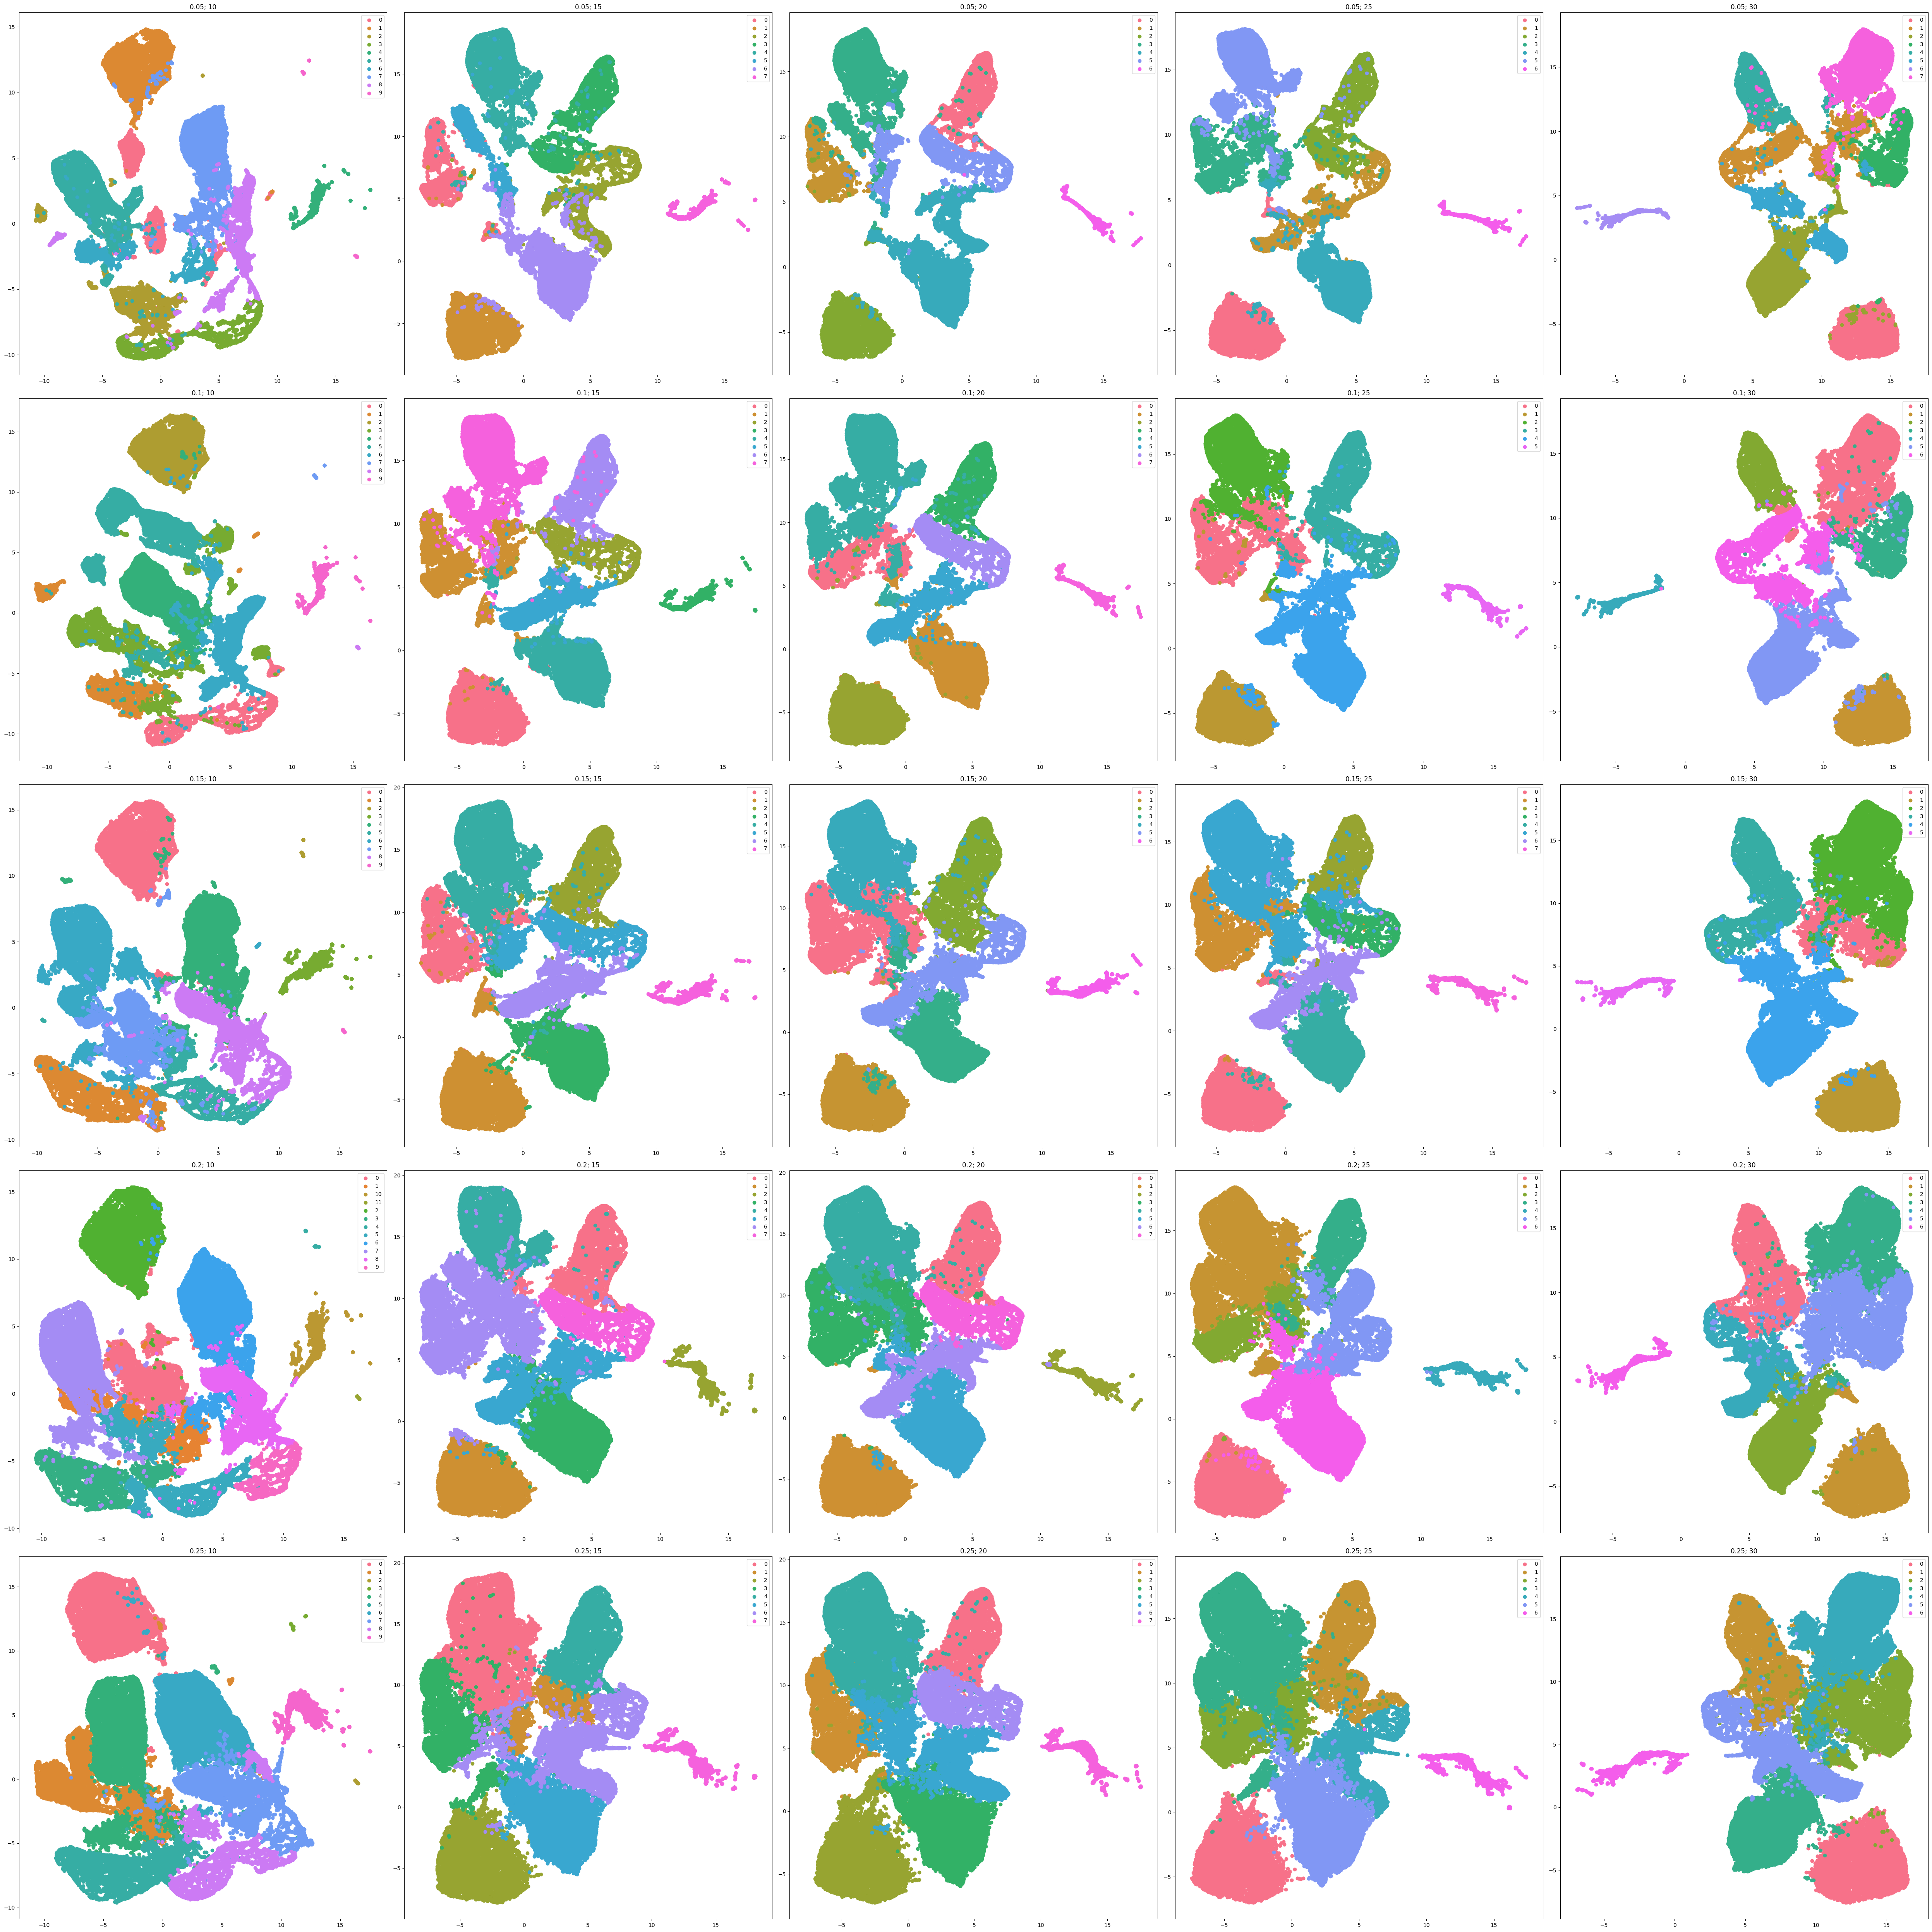

In [10]:
from laminatools import umap, plot
import matplotlib.pyplot as plt
import itertools as it
import numpy as np


binsize = 100000

df = umap.concatenate_condition_frames(
    {condition: frames[condition][binsize] for condition in conditions}
)
df = df.loc[:, ~df.columns.str.contains('LAP2alpha')]

fig, axs = plt.subplots(5, 5)
for (min_dist, n_neighbours), ax in zip(
    it.product(
        [0.05, 0.1, 0.15, 0.2, 0.25], 
        [10, 15, 20, 25, 30]
    ), 
    axs.reshape(25)
):
    embedding, umap_graph = umap.umap_embedding(
        np.log1p(df),
        random_state = 427385,
        min_dist = min_dist,
        n_neighbors = n_neighbours
    )
    communities = umap.louvain_communities(umap_graph, 0.1)
    umap.add_community_annotation(embedding, communities, 'louvain')
    
    plot.plot_embedding_categorical(embedding, 'louvain', ax)
    ax.set_title(f'{min_dist}; {n_neighbours}')
    
fig.set_figwidth(50)
fig.set_figheight(50)
fig.tight_layout()
fig.savefig('../plots/genome_umap_parameter_search.png')

In [7]:
from laminatools import umap, plot
import numpy as np
import gc


# use_multiprocessing = False
# here we only compute 5000 upwards since spectral initialization of memory fails with 200, 1000 binsize
for binsize in [5000]:
    print(binsize)
    binsize_conditions = {
        condition: frames[condition][binsize] for condition in conditions
    }
    
    binsize_frame = umap.concatenate_condition_frames(
        binsize_conditions,
        add_key_to_index = True
    )

    binsize_frame = np.log1p(binsize_frame)

    embedding_data = binsize_frame.drop(
        columns = binsize_frame.columns[binsize_frame.columns.str.contains('LAP2alpha')]
    )

    print('compute umap embedding')
    embedding, umap_graph = umap.umap_embedding(
        embedding_data,
        random_state = 427385,
        min_dist = 0.25,
        n_neighbors = 25
    )
    
    print('computing louvain communities')
    louvain_columns = umap.annotate_multiple_resolutions(
        embedding,
        umap_graph,
        [0.1]
    )
    
    for condition in conditions:
        hdf_key = f'{condition}_{binsize}'
        
        condition_frame = frames[condition][binsize]
        state_frame = state_frames[condition][binsize] 
        
        condition_embedding = embedding.loc[
            embedding.index.str.endswith(condition),
            :
        ]
        
        condition_embedding.index = [
            i.replace(f'_{condition}', '') for i in condition_embedding.index
        ]
        
        print('annotating embedding', condition)
        condition_embedding = pd.concat(
            [condition_embedding, state_frame, condition_frame],
            axis = 1,
            join = 'inner'
        )

        print('saving annotated embedding', condition)
        condition_embedding.to_hdf(
            '../embeddings_genome.h5',
            hdf_key,
            mode = 'a'
        )

        print('plotting annotated embedding', condition)
        annotation_columns = (
            condition_frame.columns.to_list() + 
            state_frame.columns.to_list() + 
            louvain_columns
        )

        plot.plot_and_save_annotated_embedding(
            condition_embedding,
            annotation_columns,
            f'../plots/umap_{condition}_{binsize}.png'
        )

    del embedding, umap_graph
    gc.collect()

/users/daniel.malzl/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5000
compute umap embedding


/users/daniel.malzl/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


annotating embedding WT
saving annotated embedding WT
plotting annotated embedding WT


/groups/pavri/bioinfo/daniel/lamina/notebooks/laminatools/plot.py:179: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/groups/pavri/bioinfo/daniel/lamina/notebooks/laminatools/plot.py:182: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(plotfile, dpi = 300)


annotating embedding KO
saving annotated embedding KO
plotting annotated embedding KO


/groups/pavri/bioinfo/daniel/lamina/notebooks/laminatools/plot.py:179: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/groups/pavri/bioinfo/daniel/lamina/notebooks/laminatools/plot.py:182: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(plotfile, dpi = 300)


In [9]:
print('ready')

ready
